## Imports

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from flirpy.io.fff import Fff
from scipy.constants import c, h, k
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Tensor de Temperatura

In [31]:
def segment_image(image):
    """Divide una imagen en 9 segmentos."""
    h, w = image.shape
    segments = []
    for i in range(3):
        for j in range(3):
            segment = image[i*h//3:(i+1)*h//3, j*w//3:(j+1)*w//3]
            segments.append(segment)
    return segments

def calculate_zonal_statistics(image):
    """Calcula estadísticas zonales para una imagen."""
    return {
        'mean': np.mean(image),
        'std': np.std(image),
        'min': np.min(image),
        'max': np.max(image),
        'median': np.median(image)
    }

def planck(wavelength, temperature):
    """
    Calculate spectral radiance using Planck's law.

    :param wavelength: Wavelength in meters
    :param temperature: Temperature in Kelvin
    :return: Spectral radiance in W⋅sr^−1⋅m^−3
    """
    return (2 * h * c**2) / (wavelength**5 * (np.exp((h * c) / (wavelength * k * temperature)) - 1))

def apply_radiometric_corrections(raw_counts, metadata):
    """
    Apply full radiometric corrections to raw sensor counts.

    :param raw_counts: Raw sensor counts
    :param metadata: Dictionary containing camera and environmental metadata
    :return: Corrected temperature in Celsius
    """
    # Extract metadata
    R1 = metadata['Planck R1']
    R2 = metadata['Planck R2']
    B = metadata['Planck B']
    F = metadata['Planck F']
    O = metadata['Planck O']
    emissivity = metadata['Emissivity']
    distance = metadata['Object Distance']
    atm_temp = metadata['Atmospheric Temperature'] + 273.15  # Convert to Kelvin
    refl_temp = metadata['Reflected Apparent Temperature'] + 273.15  # Convert to Kelvin
    humidity = metadata['Relative Humidity']

    # Atmospheric transmission calculation
    X = metadata['Atmospheric Trans X']
    alpha1 = metadata['Atmospheric Trans Alpha 1']
    alpha2 = metadata['Atmospheric Trans Alpha 2']
    beta1 = metadata['Atmospheric Trans Beta 1']
    beta2 = metadata['Atmospheric Trans Beta 2']

    tau = X * np.exp(-np.sqrt(distance) * (alpha1 + beta1 * np.sqrt(humidity))) + \
          (1 - X) * np.exp(-np.sqrt(distance) * (alpha2 + beta2 * np.sqrt(humidity)))

    # Convert raw to radiance
    raw_refl = R1 / (R2 * (np.exp(B / refl_temp) - F)) - O
    raw_atm = R1 / (R2 * (np.exp(B / atm_temp) - F)) - O

    # Apply radiometric corrections
    raw_obj = (raw_counts - (1 - emissivity) * tau * raw_refl -
               (1 - tau) * raw_atm) / (emissivity * tau)

    # Convert corrected radiance to temperature
    corrected_temp = B / np.log(R1 / (R2 * (raw_obj + O)) + F) - 273.15  # Convert to Celsius

    return corrected_temp

def process_thermal_image(file_path):
    # Load an FFF file
    fff_reader = Fff(file_path)

    # Read the raw thermal image
    raw_image = fff_reader.get_image()

    # Extract the metadata
    metadata = fff_reader.meta
    metadata['file_path'] = file_path

    # Apply radiometric corrections
    thermal_image_corrected = apply_radiometric_corrections(raw_image, metadata)

    # Get the temperature range from the metadata
    min_temp = float(metadata['CameraTemperatureRangeMin'])
    max_temp = float(metadata['CameraTemperatureRangeMax'])

    # Clip values to the camera's temperature range
    thermal_image_clipped = np.clip(thermal_image_corrected, min_temp, max_temp)

    # Calculate global statistics
    raw_global_stats = calculate_zonal_statistics(raw_image)
    corrected_global_stats = calculate_zonal_statistics(thermal_image_clipped)

    # Calculate segment statistics
    raw_segments = segment_image(raw_image)
    corrected_segments = segment_image(thermal_image_clipped)
    raw_segment_stats = [calculate_zonal_statistics(segment) for segment in raw_segments]
    corrected_segment_stats = [calculate_zonal_statistics(segment) for segment in corrected_segments]

    return raw_image, thermal_image_clipped, metadata, raw_global_stats, corrected_global_stats, raw_segment_stats, corrected_segment_stats

def process_fff_files(directory, label, limit=None):
    """
    Process FFF files in the directory and return sorted data with labels.

    :param directory: Path to the directory containing FFF files
    :param label: Label for the current directory
    :param limit: Optional. Maximum number of files to process
    :return: Sorted list of tuples containing processed data
    """
    data = []
    problematic_files = []

    # Get list of FFF files
    fff_files = [f for f in os.listdir(directory) if f.endswith('.fff')]

    # Apply limit if specified
    if limit is not None:
        fff_files = fff_files[:limit]

    # Create progress bar
    for filename in tqdm(fff_files, desc=f"Processing files in {label}"):
        file_path = os.path.join(directory, filename)
        try:
            raw_image, corrected_image, metadata, raw_global_stats, corrected_global_stats, raw_segment_stats, corrected_segment_stats = process_thermal_image(file_path)

            # Try to get timestamp from 'Datetime (UTC)' field
            timestamp_str = metadata.get('Datetime (UTC)', '')
            if timestamp_str:
                try:
                    timestamp = datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S")
                except ValueError:
                    raise ValueError(f"Could not parse timestamp '{timestamp_str}' for file {filename}")
            else:
                # If 'Datetime (UTC)' is not available, use 'Timestamp' field
                timestamp_unix = metadata.get('Timestamp')
                if timestamp_unix is None:
                    raise ValueError(f"No timestamp information found for file {filename}")
                timestamp = datetime.utcfromtimestamp(timestamp_unix)

            data.append((timestamp, raw_image, corrected_image, filename, label, raw_global_stats, corrected_global_stats, raw_segment_stats, corrected_segment_stats))
        except Exception as e:
            print(f"Error processing file {filename}: {str(e)}")
            problematic_files.append((filename, str(e)))

    if problematic_files:
        print("\nProblematic files summary:")
        for filename, error in problematic_files:
            print(f"  {filename}: {error}")

    return sorted(data, key=lambda x: x[0])

def create_time_series_tensor(sorted_data, max_images=1000):
    """Create 3D tensors and lists of statistics from sorted thermal images."""
    if not sorted_data:
        raise ValueError("No data to process")

    # Use dimensions from the first image
    height, width = sorted_data[0][1].shape
    num_images = min(len(sorted_data), max_images)

    raw_tensor = np.zeros((height, width, num_images))
    corrected_tensor = np.zeros((height, width, num_images))
    timestamps = []
    filenames = []
    labels = []
    raw_global_stats_list = []
    corrected_global_stats_list = []
    raw_segment_stats_list = []
    corrected_segment_stats_list = []

    for i in range(num_images):
        timestamp, raw_image, corrected_image, filename, label, raw_global_stats, corrected_global_stats, raw_segment_stats, corrected_segment_stats = sorted_data[i]
        raw_tensor[:,:,i] = raw_image
        corrected_tensor[:,:,i] = corrected_image
        timestamps.append(timestamp)
        filenames.append(filename)
        labels.append(label)
        raw_global_stats_list.append(raw_global_stats)
        corrected_global_stats_list.append(corrected_global_stats)
        raw_segment_stats_list.append(raw_segment_stats)
        corrected_segment_stats_list.append(corrected_segment_stats)

    return raw_tensor, corrected_tensor, timestamps, filenames, labels, raw_global_stats_list, corrected_global_stats_list, raw_segment_stats_list, corrected_segment_stats_list

In [32]:
def visualize_raw_and_corrected(raw_tensor, corrected_tensor, timestamps, labels, index):
    """
    Visualiza una comparación entre la imagen térmica raw y la corregida para un índice específico.

    :param raw_tensor: Tensor 3D de imágenes térmicas raw
    :param corrected_tensor: Tensor 3D de imágenes térmicas corregidas
    :param timestamps: Lista de marcas de tiempo para cada imagen
    :param labels: Lista de etiquetas para cada imagen
    :param index: Índice de la imagen a visualizar
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Imagen raw
    im1 = ax1.imshow(raw_tensor[:,:,index], cmap='inferno')
    ax1.set_title('Raw Thermal Image')
    fig.colorbar(im1, ax=ax1, label='Raw values')

    # Imagen corregida
    im2 = ax2.imshow(corrected_tensor[:,:,index], cmap='inferno')
    ax2.set_title('Corrected Thermal Image')
    fig.colorbar(im2, ax=ax2, label='Temperature (°C)')

    # Título general con información de timestamp y etiqueta
    fig.suptitle(f"Time: {timestamps[index]}, Label: {labels[index]}")

    # Eliminar ejes
    ax1.axis('off')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

In [33]:
# Main execution
directories = [
    'data/Mix',
    'data/Nublado',
    'data/Emisiones',
    'data/Despejado',
    'data/DiarioRaw'
]

limit = 200  # limit per directory
all_data = []

for directory in directories:
    label = os.path.basename(directory)
    sorted_data = process_fff_files(directory, label, limit=limit)
    all_data.extend(sorted_data)

    print(f"Processed {len(sorted_data)} files from {label}.")
    if sorted_data:
        print(f"Date range for {label}: from {sorted_data[0][0]} to {sorted_data[-1][0]}")
    print("\n")

# Sort all data by timestamp and remove duplicates
all_data.sort(key=lambda x: x[0])
all_data = list(dict((x[0], x) for x in all_data).values())  # Remove duplicates based on timestamp

print(f"Total processed files after removing duplicates: {len(all_data)}")
if all_data:
    print(f"Overall date range: from {all_data[0][0]} to {all_data[-1][0]}")

# Create temperature tensors and statistics lists
raw_tensor, corrected_tensor, timestamps, filenames, labels, raw_global_stats, corrected_global_stats, raw_segment_stats, corrected_segment_stats = create_time_series_tensor(all_data)

Processing files in Mix: 100%|██████████| 200/200 [00:03<00:00, 66.64it/s]


Processed 200 files from Mix.
Date range for Mix: from 2022-08-05 19:48:31 to 2022-09-01 20:18:14




Processing files in Nublado: 100%|██████████| 200/200 [00:02<00:00, 68.19it/s]


Processed 200 files from Nublado.
Date range for Nublado: from 2023-12-08 07:56:59 to 2023-12-08 21:29:59




Processing files in Emisiones: 100%|██████████| 200/200 [00:02<00:00, 66.67it/s]


Processed 200 files from Emisiones.
Date range for Emisiones: from 2022-10-03 22:18:04 to 2022-11-03 05:07:41




Processing files in Despejado: 100%|██████████| 200/200 [00:02<00:00, 71.54it/s]


Processed 200 files from Despejado.
Date range for Despejado: from 2022-08-05 19:48:31 to 2022-09-01 23:33:15




Processing files in DiarioRaw: 100%|██████████| 200/200 [00:03<00:00, 57.16it/s]


Processed 200 files from DiarioRaw.
Date range for DiarioRaw: from 2024-03-03 22:56:15 to 2024-03-04 11:31:15


Total processed files after removing duplicates: 819
Overall date range: from 2022-08-05 19:48:31 to 2024-03-04 11:31:15


In [38]:
print(corrected_global_stats[0])

{'mean': np.float64(-0.5582801317979893), 'std': np.float64(3.2819176834888886), 'min': np.float64(-11.05651167105134), 'max': np.float64(3.581273425949007), 'median': np.float64(0.7641850512044357)}


In [39]:
print(corrected_segment_stats[0][0])

{'mean': np.float64(-5.728555789804665), 'std': np.float64(2.202003498918921), 'min': np.float64(-11.05651167105134), 'max': np.float64(-0.7922466723566117), 'median': np.float64(-5.605449780831236)}


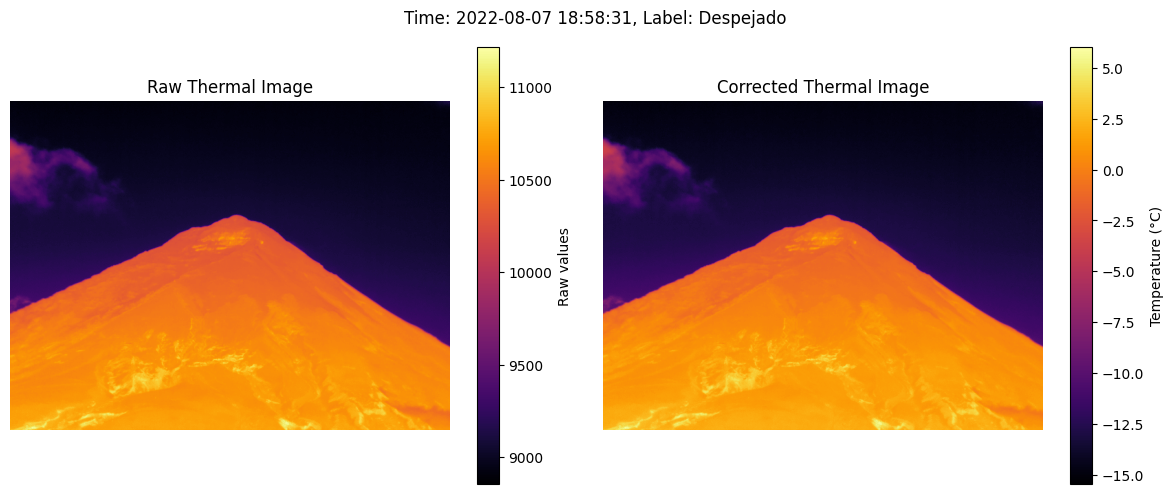

In [36]:
# Visualizar una imagen raw y su correspondiente imagen corregida
visualize_raw_and_corrected(raw_tensor, corrected_tensor, timestamps, labels, 50)

## Tensor de bordes

In [64]:
def apply_canny(image, low_threshold=100, high_threshold=200):
    """
    Aplica la detección de bordes Canny a una imagen.
    
    :param image: Imagen de entrada
    :param low_threshold: Umbral inferior para la detección de bordes
    :param high_threshold: Umbral superior para la detección de bordes
    :return: Imagen con bordes detectados
    """
    return cv2.Canny(image.astype(np.uint8), low_threshold, high_threshold)

def calculate_edge_statistics(edge_image):
    """
    Calcula estadísticas para una imagen de bordes.
    Esta función es específica para el análisis Canny.
    
    :param edge_image: Imagen de bordes (resultado de Canny)
    :return: Diccionario con estadísticas
    """
    return {
        'edge_density': np.mean(edge_image) / 255.0,  # Normalizado a [0, 1]
        'total_edges': np.sum(edge_image) / 255,
        'non_zero_ratio': np.count_nonzero(edge_image) / edge_image.size
    }

def process_canny_image(thermal_image):
    """
    Procesa una imagen térmica aplicando Canny y calculando estadísticas.
    Esta función es específica para el análisis Canny.
    
    :param thermal_image: Imagen térmica de entrada
    :return: Imagen Canny, estadísticas globales y estadísticas de segmentos
    """
    # Normalizar la imagen térmica al rango 0-255
    normalized_image = cv2.normalize(thermal_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    # Aplicar ecualización del histograma para mejorar el contraste
    equalized_image = cv2.equalizeHist(normalized_image)
    
    canny_image = apply_canny(equalized_image)
    global_stats = calculate_edge_statistics(canny_image)
    
    segments = segment_image(canny_image)
    segment_stats = [calculate_edge_statistics(segment) for segment in segments]
    
    return canny_image, global_stats, segment_stats

def create_canny_tensor(thermal_tensor):
    """
    Crea un tensor Canny y calcula estadísticas para un tensor térmico.
    Esta función es específica para el análisis Canny.
    
    :param thermal_tensor: Tensor 3D de imágenes térmicas
    :return: Tensor Canny, lista de estadísticas globales, lista de estadísticas de segmentos
    """
    height, width, num_images = thermal_tensor.shape
    canny_tensor = np.zeros((height, width, num_images), dtype=np.uint8)
    global_stats_list = []
    segment_stats_list = []
    
    for i in range(num_images):
        canny_image, global_stats, segment_stats = process_canny_image(thermal_tensor[:,:,i])
        canny_tensor[:,:,i] = canny_image
        global_stats_list.append(global_stats)
        segment_stats_list.append(segment_stats)
    
    return canny_tensor, global_stats_list, segment_stats_list

In [57]:
def visualize_corrected_and_canny(corrected_tensor, canny_tensor, timestamps, labels, index):
    """
    Visualiza una comparación entre la imagen térmica corregida y la imagen Canny para un índice específico.

    :param corrected_tensor: Tensor 3D de imágenes térmicas corregidas
    :param canny_tensor: Tensor 3D de imágenes Canny
    :param timestamps: Lista de marcas de tiempo para cada imagen
    :param labels: Lista de etiquetas para cada imagen
    :param index: Índice de la imagen a visualizar
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Imagen térmica corregida
    im1 = ax1.imshow(corrected_tensor[:,:,index], cmap='inferno')
    ax1.set_title('Corrected Thermal Image')
    fig.colorbar(im1, ax=ax1, label='Temperature (°C)')

    # Imagen Canny en blanco y negro
    ax2.imshow(canny_tensor[:,:,index], cmap='gray', vmin=0, vmax=255)
    ax2.set_title('Canny Edge Detection')

    # Título general con información de timestamp y etiqueta
    fig.suptitle(f"Time: {timestamps[index]}, Label: {labels[index]}")

    # Eliminar ejes
    ax1.axis('off')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

In [65]:
canny_tensor, canny_global_stats, canny_segment_stats = create_canny_tensor(corrected_tensor)

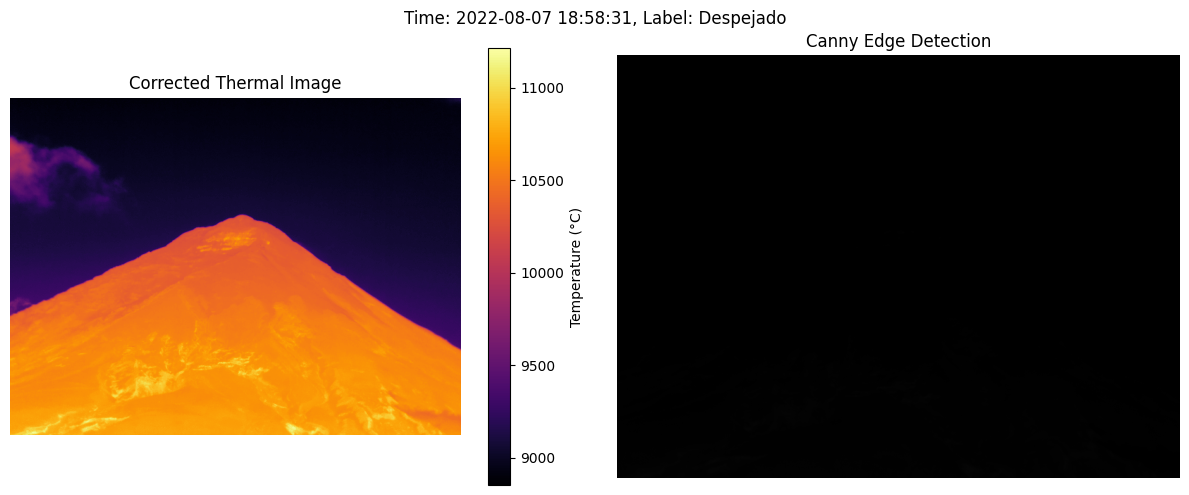

In [66]:
visualize_corrected_and_canny(raw_tensor, corrected_tensor, timestamps, labels, 50)

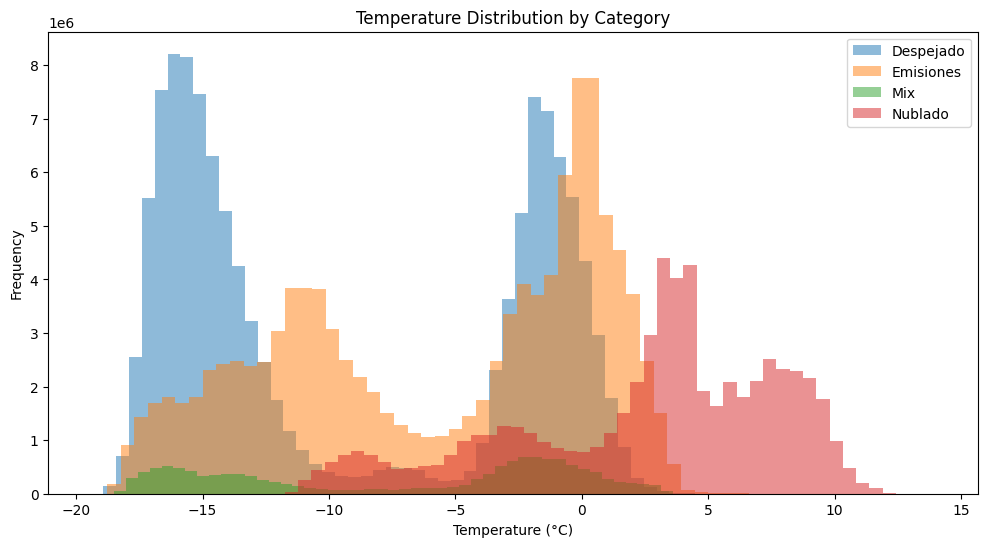

In [23]:
# Create temperature tensor
tensor, timestamps, filenames, labels, global_stats, segment_stats = create_time_series_tensor(all_data)

# Calculate global temperature range
global_min, global_max = get_global_temperature_range(tensor)



In [ ]:
# Visualize temperature distribution by category
def plot_temperature_distribution_by_category(tensor, labels):
    categories = set(labels)
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for category in categories:
        category_data = tensor[:,:,np.array(labels) == category].flatten()
        ax.hist(category_data, bins=50, alpha=0.5, label=category)
    
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Frequency')
    ax.set_title('Temperature Distribution by Category')
    ax.legend()
    plt.show()

plot_temperature_distribution_by_category(tensor, labels)

## Functions

In [15]:
def planck(wavelength, temperature):
    """
    Calculate spectral radiance using Planck's law.

    :param wavelength: Wavelength in meters
    :param temperature: Temperature in Kelvin
    :return: Spectral radiance in W⋅sr^−1⋅m^−3
    """
    return (2 * h * c**2) / (wavelength**5 * (np.exp((h * c) / (wavelength * k * temperature)) - 1))

def apply_radiometric_corrections(raw_counts, metadata):
    """
    Apply full radiometric corrections to raw sensor counts.

    :param raw_counts: Raw sensor counts
    :param metadata: Dictionary containing camera and environmental metadata
    :return: Corrected temperature in Celsius
    """
    # Extract metadata
    R1 = metadata['Planck R1']
    R2 = metadata['Planck R2']
    B = metadata['Planck B']
    F = metadata['Planck F']
    O = metadata['Planck O']
    emissivity = metadata['Emissivity']
    distance = metadata['Object Distance']
    atm_temp = metadata['Atmospheric Temperature'] + 273.15  # Convert to Kelvin
    refl_temp = metadata['Reflected Apparent Temperature'] + 273.15  # Convert to Kelvin
    humidity = metadata['Relative Humidity']

    # Atmospheric transmission calculation
    X = metadata['Atmospheric Trans X']
    alpha1 = metadata['Atmospheric Trans Alpha 1']
    alpha2 = metadata['Atmospheric Trans Alpha 2']
    beta1 = metadata['Atmospheric Trans Beta 1']
    beta2 = metadata['Atmospheric Trans Beta 2']

    tau = X * np.exp(-np.sqrt(distance) * (alpha1 + beta1 * np.sqrt(humidity))) + \
          (1 - X) * np.exp(-np.sqrt(distance) * (alpha2 + beta2 * np.sqrt(humidity)))

    # Convert raw to radiance
    raw_refl = R1 / (R2 * (np.exp(B / refl_temp) - F)) - O
    raw_atm = R1 / (R2 * (np.exp(B / atm_temp) - F)) - O

    # Apply radiometric corrections
    raw_obj = (raw_counts - (1 - emissivity) * tau * raw_refl -
               (1 - tau) * raw_atm) / (emissivity * tau)

    # Convert corrected radiance to temperature
    corrected_temp = B / np.log(R1 / (R2 * (raw_obj + O)) + F) - 273.15  # Convert to Celsius

    return corrected_temp

def process_thermal_image(file_path):
    # Load an FFF file
    fff_reader = Fff(file_path)

    # Read the raw thermal image
    raw_image = fff_reader.get_image()

    # Extract the metadata
    metadata = fff_reader.meta
    metadata['file_path'] = file_path

    # Apply radiometric corrections
    thermal_image_corrected = apply_radiometric_corrections(raw_image, metadata)

    # Get the temperature range from the metadata
    min_temp = float(metadata['CameraTemperatureRangeMin'])
    max_temp = float(metadata['CameraTemperatureRangeMax'])

    # Clip values to the camera's temperature range
    thermal_image_clipped = np.clip(thermal_image_corrected, min_temp, max_temp)

    # Normalize the image to [0, 1] range for visualization
    thermal_image_normalized = (thermal_image_clipped - min_temp) / (max_temp - min_temp)

    return thermal_image_clipped, thermal_image_normalized, metadata

def process_fff_files(directory, label, limit=None):
    """
    Process FFF files in the directory and return sorted data with labels.

    :param directory: Path to the directory containing FFF files
    :param label: Label for the current directory
    :param limit: Optional. Maximum number of files to process
    :return: Sorted list of (timestamp, thermal_image, filename, label) tuples
    """
    data = []
    problematic_files = []

    # Get list of FFF files
    fff_files = [f for f in os.listdir(directory) if f.endswith('.fff')]

    # Apply limit if specified
    if limit is not None:
        fff_files = fff_files[:limit]

    # Create progress bar
    for filename in tqdm(fff_files, desc=f"Processing files in {label}"):
        file_path = os.path.join(directory, filename)
        try:
            fff_reader = Fff(file_path)
            thermal_image_clipped, _, metadata = process_thermal_image(file_path)

            # Try to get timestamp from 'Datetime (UTC)' field
            timestamp_str = metadata.get('Datetime (UTC)', '')
            if timestamp_str:
                try:
                    timestamp = datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S")
                except ValueError:
                    raise ValueError(f"Could not parse timestamp '{timestamp_str}' for file {filename}")
            else:
                # If 'Datetime (UTC)' is not available, use 'Timestamp' field
                timestamp_unix = metadata.get('Timestamp')
                if timestamp_unix is None:
                    raise ValueError(f"No timestamp information found for file {filename}")
                timestamp = datetime.utcfromtimestamp(timestamp_unix)

            data.append((timestamp, thermal_image_clipped, filename, label))
        except Exception as e:
            print(f"Error processing file {filename}: {str(e)}")
            problematic_files.append((filename, str(e)))

    if problematic_files:
        print("\nProblematic files summary:")
        for filename, error in problematic_files:
            print(f"  {filename}: {error}")

    return sorted(data, key=lambda x: x[0])

def create_time_series_tensor(sorted_data, max_images=1000):
    """Create a 3D tensor from sorted thermal images."""
    if not sorted_data:
        raise ValueError("No data to process")

    # Use dimensions from the first image
    height, width = sorted_data[0][1].shape
    num_images = min(len(sorted_data), max_images)

    tensor = np.zeros((height, width, num_images))
    timestamps = []
    filenames = []
    labels = []

    for i in range(num_images):
        timestamp, image, filename, label = sorted_data[i]
        tensor[:,:,i] = image
        timestamps.append(timestamp)
        filenames.append(filename)
        labels.append(label)

    return tensor, timestamps, filenames, labels

def visualize_single_thermal_image(tensor, timestamps, index, global_min, global_max):
    """
    Visualize a single slice of the tensor with a fixed temperature range, adjusted colorbar height,
    and no axis ticks or labels.

    :param tensor: 3D numpy array of thermal images
    :param timestamps: List of timestamps for each image
    :param index: Index of the image to visualize
    :param global_min: Global minimum temperature for color scaling
    :param global_max: Global maximum temperature for color scaling
    """
    fig, ax = plt.subplots(figsize=(6, 4))
    im = ax.imshow(tensor[:,:,index], cmap='inferno', vmin=global_min, vmax=global_max)
    ax.set_title(f'Thermal Image at\n{timestamps[index]}')

    # Remove axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Create a divider for existing axes instance
    divider = make_axes_locatable(ax)

    # Append axes to the right of ax, with 2% width of ax
    cax = divider.append_axes("right", size="2%", pad=0.05)

    # Create colorbar in the appended axes
    # Ensure colorbar height matches the image height
    plt.colorbar(im, cax=cax, label='Temperature (°C)')

    plt.tight_layout()
    plt.show()

# Function to calculate global min and max temperatures
def get_global_temperature_range(tensor):
    return np.min(tensor), np.max(tensor)

def create_edge_detection_tensors(thermal_tensor):
        """
        Create edge detection tensors from a thermal image tensor.

        :param thermal_tensor: 3D numpy array (height, width, time) of thermal images
        :return: Dictionary containing edge detection tensors
        """
        height, width, time = thermal_tensor.shape

        # Initialize tensor for Canny edge detection
        canny_tensor = np.zeros((height, width, time), dtype=np.uint8)

        for t in range(time):
            # Normalize the image to 0-255 range
            normalized_image = cv2.normalize(thermal_tensor[:,:,t], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

            # Canny edge detection
            canny_tensor[:,:,t] = cv2.Canny(normalized_image, 100, 200)

        return {
            'canny': canny_tensor
        }

def visualize_edge_detection_comparison(thermal_tensor, edge_tensors, time_index):
        """
        Visualize a comparison of the original thermal image and edge detection results at a specific time index.

        :param thermal_tensor: Original 3D thermal image tensor
        :param edge_tensors: Dictionary containing edge detection tensors
        :param time_index: Index of the time slice to visualize
        """
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Original thermal image
        im_thermal = axes[0].imshow(thermal_tensor[:,:,time_index], cmap='inferno')
        axes[0].set_title('Original Thermal Image')
        fig.colorbar(im_thermal, ax=axes[0], label='Temperature')

        # Canny edge detection
        axes[1].imshow(edge_tensors['canny'][:,:,time_index], cmap='gray')
        axes[1].set_title('Canny Edge Detection')

        for ax in axes:
            ax.axis('off')

        plt.tight_layout()
        plt.show()

def create_thermal_depth_tensors(thermal_tensor):
    """
    Create tensors with thermal depth estimation from a thermal image tensor.

    :param thermal_tensor: 3D numpy array (height, width, time) of thermal images
    :return: Dictionary containing thermal depth estimation tensors
    """
    height, width, time = thermal_tensor.shape

    gradient_tensor = np.zeros((height, width, time), dtype=np.float32)

    for t in range(time):
        # Normalize the image to 0-1 range
        normalized_image = cv2.normalize(thermal_tensor[:,:,t], None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        # Estimate depth gradients
        sobelx = cv2.Sobel(normalized_image, cv2.CV_32F, 1, 0, ksize=3)
        sobely = cv2.Sobel(normalized_image, cv2.CV_32F, 0, 1, ksize=3)
        gradient = np.sqrt(sobelx**2 + sobely**2)
        gradient_tensor[:,:,t] = gradient

    return {
        'gradient': gradient_tensor
    }

def visualize_thermal_depth_comparison(thermal_tensor, depth_tensors, time_index):
    """
    Visualize a comparison of the original thermal image and depth estimation results at a specific time index.

    :param thermal_tensor: Original 3D thermal image tensor
    :param depth_tensors: Dictionary containing thermal depth estimation tensors
    :param time_index: Index of the time slice to visualize
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Original thermal image
    im_thermal = axes[0].imshow(thermal_tensor[:,:,time_index], cmap='inferno')
    axes[0].set_title('Original Thermal Image')
    fig.colorbar(im_thermal, ax=axes[0], label='Temperature')

    # Depth gradient estimation
    im_gradient = axes[1].imshow(depth_tensors['gradient'][:,:,time_index], cmap='viridis')
    axes[1].set_title('Depth Gradient Estimation')
    fig.colorbar(im_gradient, ax=axes[1], label='Gradient Magnitude')

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

## Thermal Images Paths

In [4]:
# Main execution
directories = [
    'data/Mix',
    'data/Nublado',
    'data/Emisiones',
    'data/Despejado',
    'data/DiarioRaw'
]

limit = 400  # limit per directory
all_data = []

for directory in directories:
    label = os.path.basename(directory)
    sorted_data = process_fff_files(directory, label, limit=limit)
    all_data.extend(sorted_data)

    print(f"Processed {len(sorted_data)} files from {label}.")
    if sorted_data:
        print(f"Date range for {label}: from {sorted_data[0][0]} to {sorted_data[-1][0]}")
    print("\n")

# Sort all data by timestamp and remove duplicates
all_data.sort(key=lambda x: x[0])
all_data = list(dict((x[0], x) for x in all_data).values())  # Remove duplicates based on timestamp

print(f"Total processed files after removing duplicates: {len(all_data)}")
if all_data:
    print(f"Overall date range: from {all_data[0][0]} to {all_data[-1][0]}")

Processing files in Mix: 100%|██████████| 400/400 [00:05<00:00, 78.73it/s]


Processed 400 files from Mix.
Date range for Mix: from 2022-08-05 19:48:31 to 2022-09-08 20:23:16




Processing files in Nublado: 100%|██████████| 400/400 [00:04<00:00, 80.87it/s]


Processed 400 files from Nublado.
Date range for Nublado: from 2023-12-08 07:56:59 to 2024-03-11 14:46:11




Processing files in Emisiones: 100%|██████████| 400/400 [00:04<00:00, 82.50it/s]


Processed 400 files from Emisiones.
Date range for Emisiones: from 2022-10-03 22:18:04 to 2022-11-12 23:22:43




Processing files in Despejado: 100%|██████████| 400/400 [00:04<00:00, 80.43it/s]


Processed 400 files from Despejado.
Date range for Despejado: from 2022-08-05 19:48:31 to 2022-09-08 23:58:16




Processing files in DiarioRaw: 100%|██████████| 384/384 [00:04<00:00, 85.40it/s]


Processed 384 files from DiarioRaw.
Date range for DiarioRaw: from 2024-03-03 22:56:15 to 2024-03-04 22:53:15


Total processed files after removing duplicates: 1584
Overall date range: from 2022-08-05 19:48:31 to 2024-03-11 14:46:11


In [5]:
# Create tensor (limit to 1000 images for memory management, adjust as needed)
tensor, timestamps, filenames, labels = create_time_series_tensor(all_data, max_images=1600)

print(f"Tensor shape: {tensor.shape}")
print(f"Time range: {timestamps[0]} to {timestamps[-1]}")
print(f"Unique labels: {set(labels)}")

# Save tensor and metadata
np.save('outputs/volcano_thermal_tensor.npy', tensor)
with open('outputs/volcano_thermal_metadata.txt', 'w') as f:
    for timestamp, filename, label in zip(timestamps, filenames, labels):
        f.write(f"{timestamp},{filename},{label}\n")

print("Tensor and metadata saved.")

Tensor shape: (480, 640, 1584)
Time range: 2022-08-05 19:48:31 to 2024-03-11 14:46:11
Unique labels: {'DiarioRaw', 'Mix', 'Nublado', 'Emisiones', 'Despejado'}
Tensor and metadata saved.


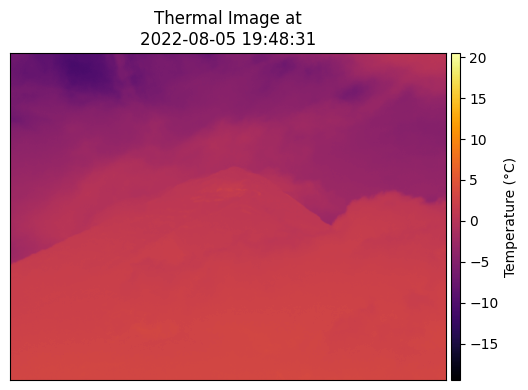

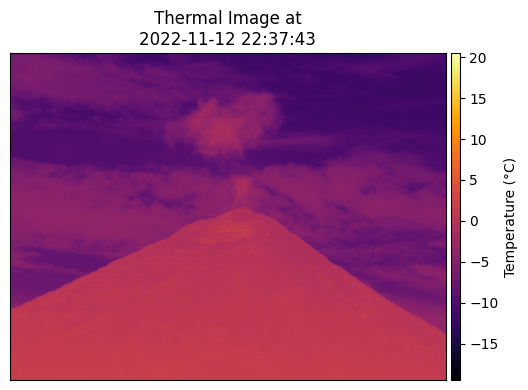

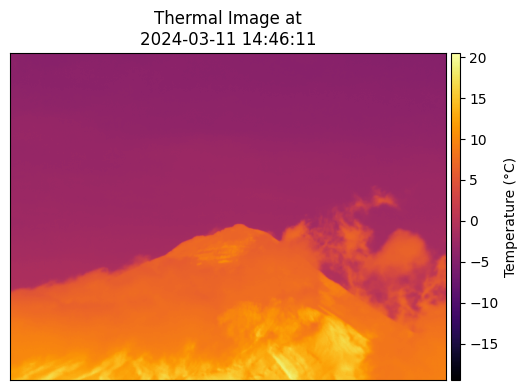

In [6]:
# Calcula el rango global de temperaturas una vez
global_min, global_max = get_global_temperature_range(tensor)

# Para visualizar imágenes específicas:
for index in [0, len(timestamps)//2, -1]:  # Primero, medio y último
    visualize_single_thermal_image(tensor, timestamps, index, global_min, global_max)

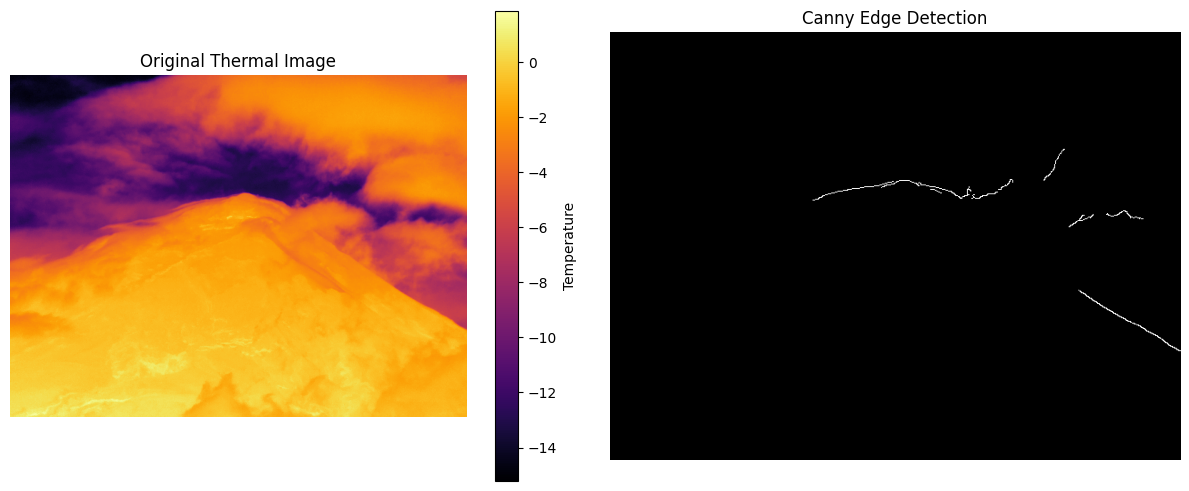

In [13]:
# Crear los tensores de detección de bordes
edge_tensors = create_edge_detection_tensors(tensor)

# Visualizar una comparación para un tiempo específico
time_index = 45  # O cualquier otro índice de tiempo que te interese
visualize_edge_detection_comparison(tensor, edge_tensors, time_index)

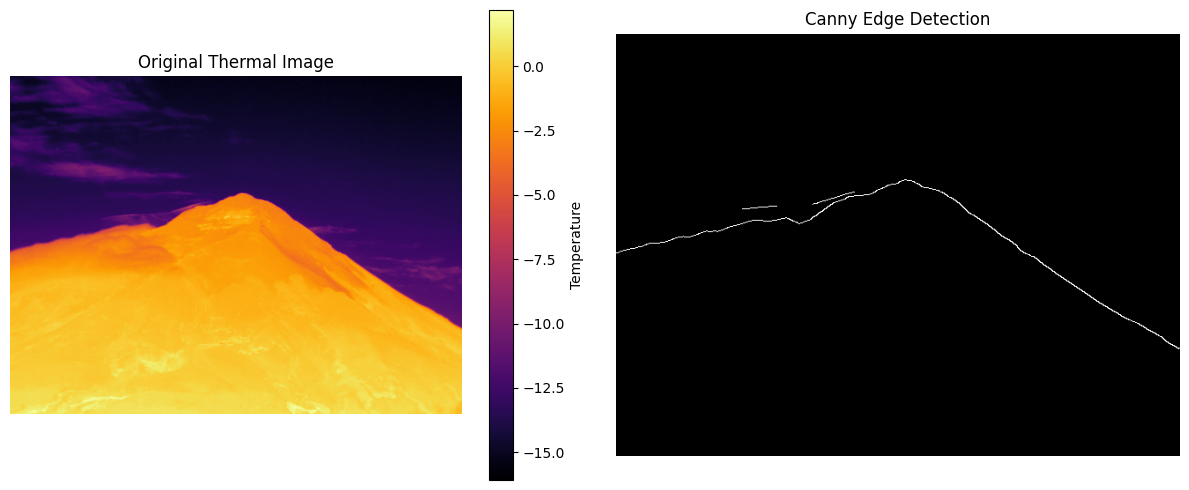

In [14]:
# Visualizar una comparación para un tiempo específico
time_index = 25  # O cualquier otro índice de tiempo que te interese
visualize_edge_detection_comparison(tensor, edge_tensors, time_index)

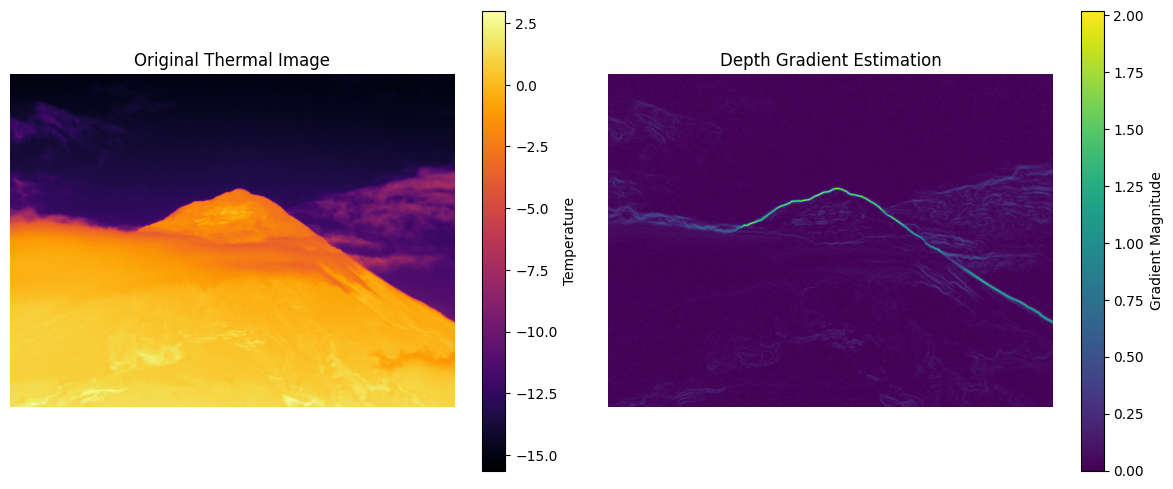

In [16]:
# Crear los tensores de estimación de profundidad térmica
depth_tensors = create_thermal_depth_tensors(tensor)

# Visualizar una comparación para un tiempo específico
time_index = 15 # O cualquier otro índice de tiempo que te interese
visualize_thermal_depth_comparison(tensor, depth_tensors, time_index)

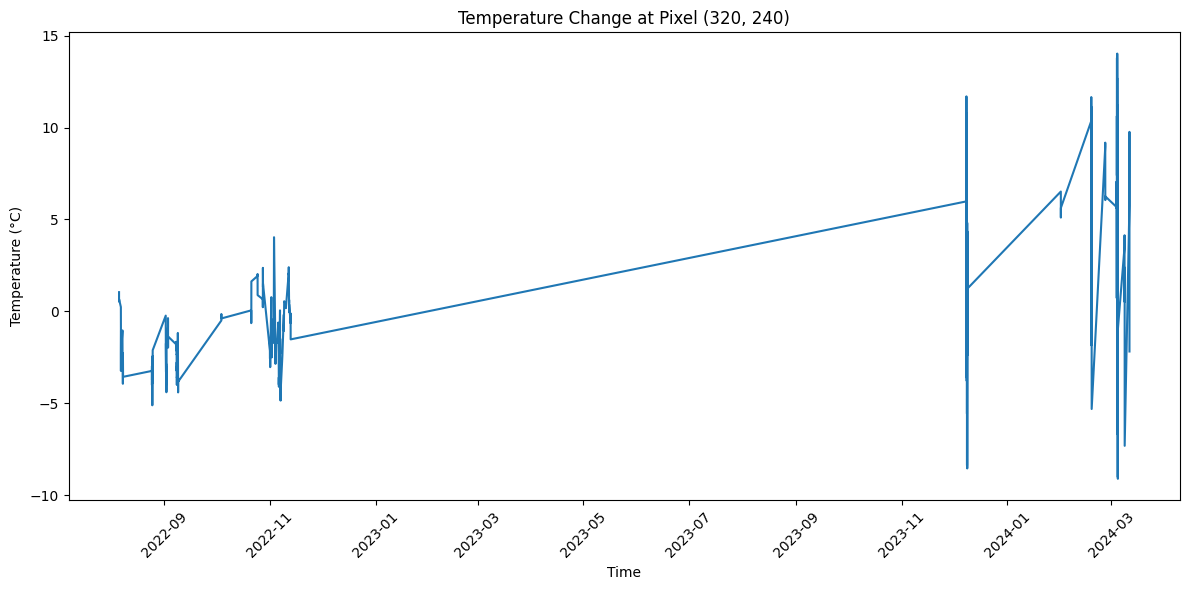

In [8]:
# Example: Plot temperature change for a specific pixel over time
pixel_x, pixel_y = 320, 240  # Center pixel, adjust as needed
pixel_temps = tensor[pixel_y, pixel_x, :]
plt.figure(figsize=(12, 6))
plt.plot(timestamps, pixel_temps)
plt.title(f'Temperature Change at Pixel ({pixel_x}, {pixel_y})')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
def create_thermal_threshold_tensor(thermal_tensor, threshold_temp):
    """
    Create a binary tensor based on temperature thresholding.

    :param thermal_tensor: 3D numpy array (height, width, time) of thermal images
    :param threshold_temp: Temperature threshold in Celsius
    :return: Dictionary containing the thresholded tensor
    """
    height, width, time = thermal_tensor.shape
    threshold_tensor = np.zeros((height, width, time), dtype=np.uint8)

    for t in range(time):
        # Apply thresholding
        threshold_tensor[:,:,t] = (thermal_tensor[:,:,t] > threshold_temp).astype(np.uint8) * 255

    return {
        'threshold': threshold_tensor
    }

def visualize_thermal_threshold_comparison(thermal_tensor, threshold_tensors, time_index, threshold_temp):
    """
    Visualize a comparison of the original thermal image and thresholded results at a specific time index.

    :param thermal_tensor: Original 3D thermal image tensor
    :param threshold_tensors: Dictionary containing thresholded tensors
    :param time_index: Index of the time slice to visualize
    :param threshold_temp: Temperature threshold used for visualization
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Original thermal image
    im_thermal = axes[0].imshow(thermal_tensor[:,:,time_index], cmap='inferno')
    axes[0].set_title('Original Thermal Image')
    fig.colorbar(im_thermal, ax=axes[0], label='Temperature (°C)')

    # Thresholded image
    axes[1].imshow(threshold_tensors['threshold'][:,:,time_index], cmap='gray')
    axes[1].set_title(f'Thresholded Image (T > {threshold_temp}°C)')

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

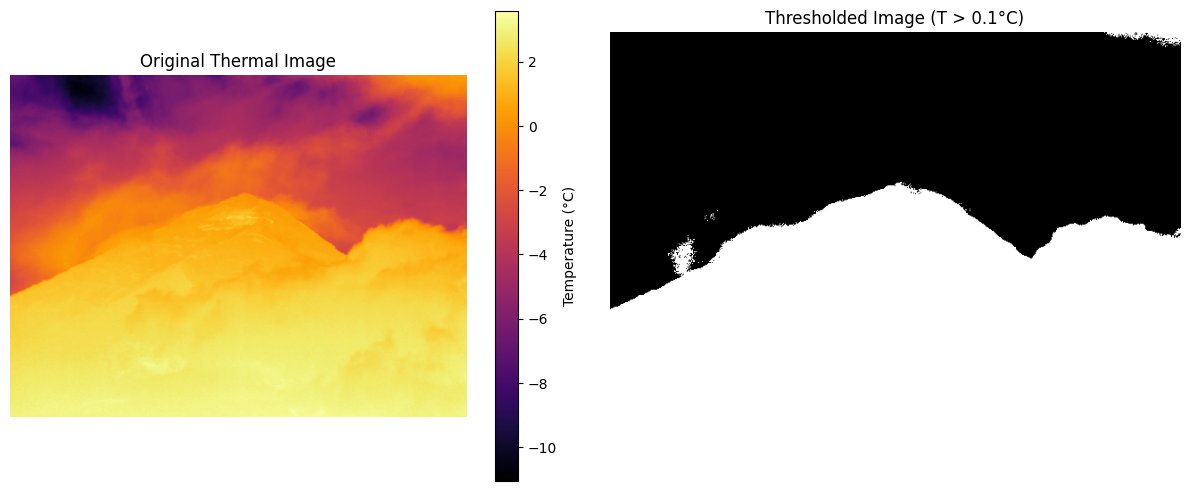

In [20]:
# Usage example
threshold_temp = 0.1  # Set your desired temperature threshold
threshold_tensors = create_thermal_threshold_tensor(tensor, threshold_temp)
visualize_thermal_threshold_comparison(tensor, threshold_tensors, time_index=0, threshold_temp=threshold_temp)